# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to collaborate, but should turn in your own answers. 

Please limit each answer to a maximum of one markdown cell, one code cell and one plot. 

Put helper functions into a separate script (e.g. `hwutils.py`) so the notebook can be focused on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


<span style='color:Blue'> 
    Collaborators: Hanyi Wang, Cecilia Liu, Yumin Wang, Mark Kim
</span>

In [1]:
# useful libraries to import

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import manifold

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

import textwrap

from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/gh/wjs3pzl11758g8crdf96rf8c0000gn/T/ipykernel_38813/1708817607.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')


- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


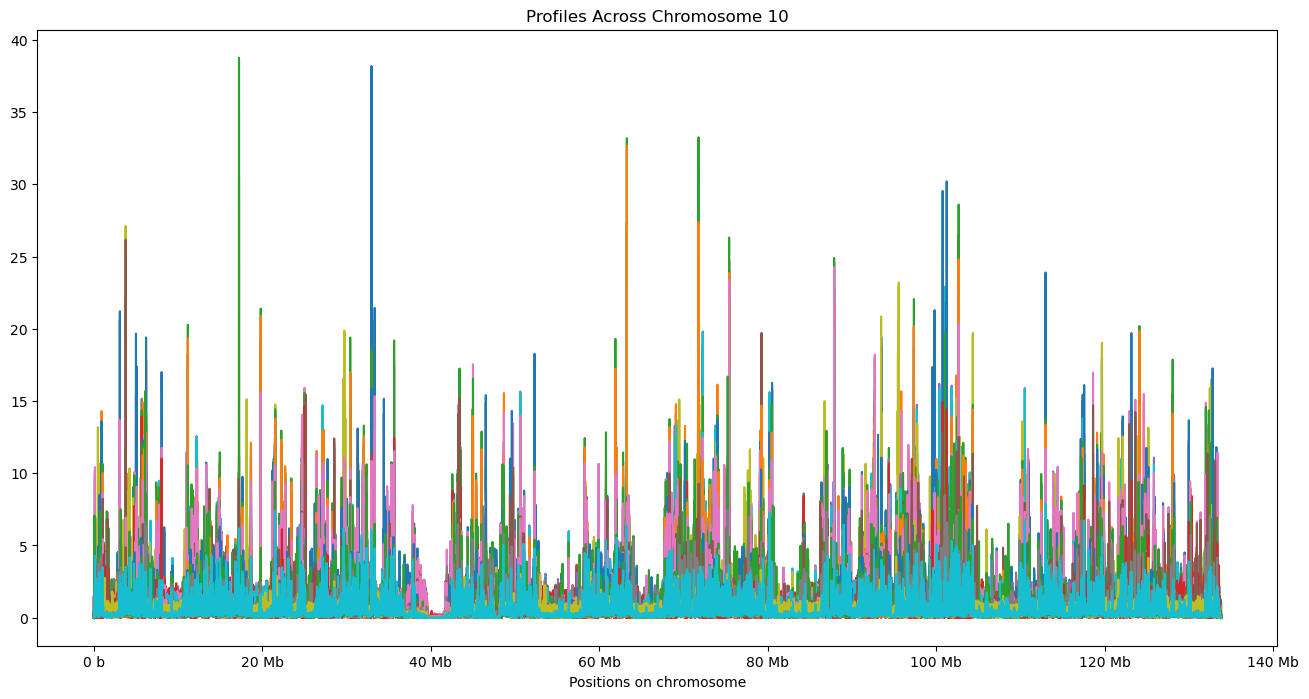

In [3]:
# get the profiles to be plotted
profiles = df.columns[3:]

# make the plot with all the profiles overlaid on each other
fig, ax = plt.subplots(figsize = (16, 8))
for i in range(profiles.shape[0]):
    profile = profiles[i]
    ax.plot(df['start'], df[profile])
    ax.xaxis.set_major_formatter(bp_formatter)
ax.set(xlabel = 'Positions on chromosome', title = "Profiles Across Chromosome 10")
    
plt.show()


<span style='color:Blue'> 
    Many signals dip on chr10 at around 40Mb, because the centromere on chr10 is around 40Mb.
</span>

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


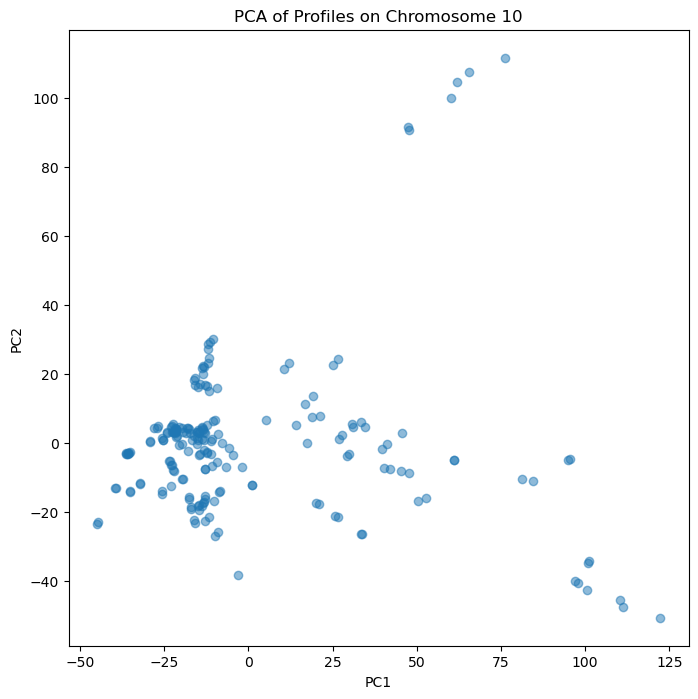

In [4]:
# data preparation ===================================================================
# the colomns that need to be removed are the first three: "chrom", "start", and "end"
df_signals = df.iloc[:, 3:]
# transpose the data frame so that the PCA is performed on the profile rather than the bins (positions)
df_signals_t = df_signals.T

# perform PCA
pca = PCA(n_components = 2)
df_signals_t_pca = pca.fit_transform(df_signals_t)

# plotting ============================================================================
fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(df_signals_t_pca[:, 0], df_signals_t_pca[:, 1], alpha = 0.5)
ax.set(xlabel = "PC1", ylabel = "PC2", title = "PCA of Profiles on Chromosome 10")
plt.show()

- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

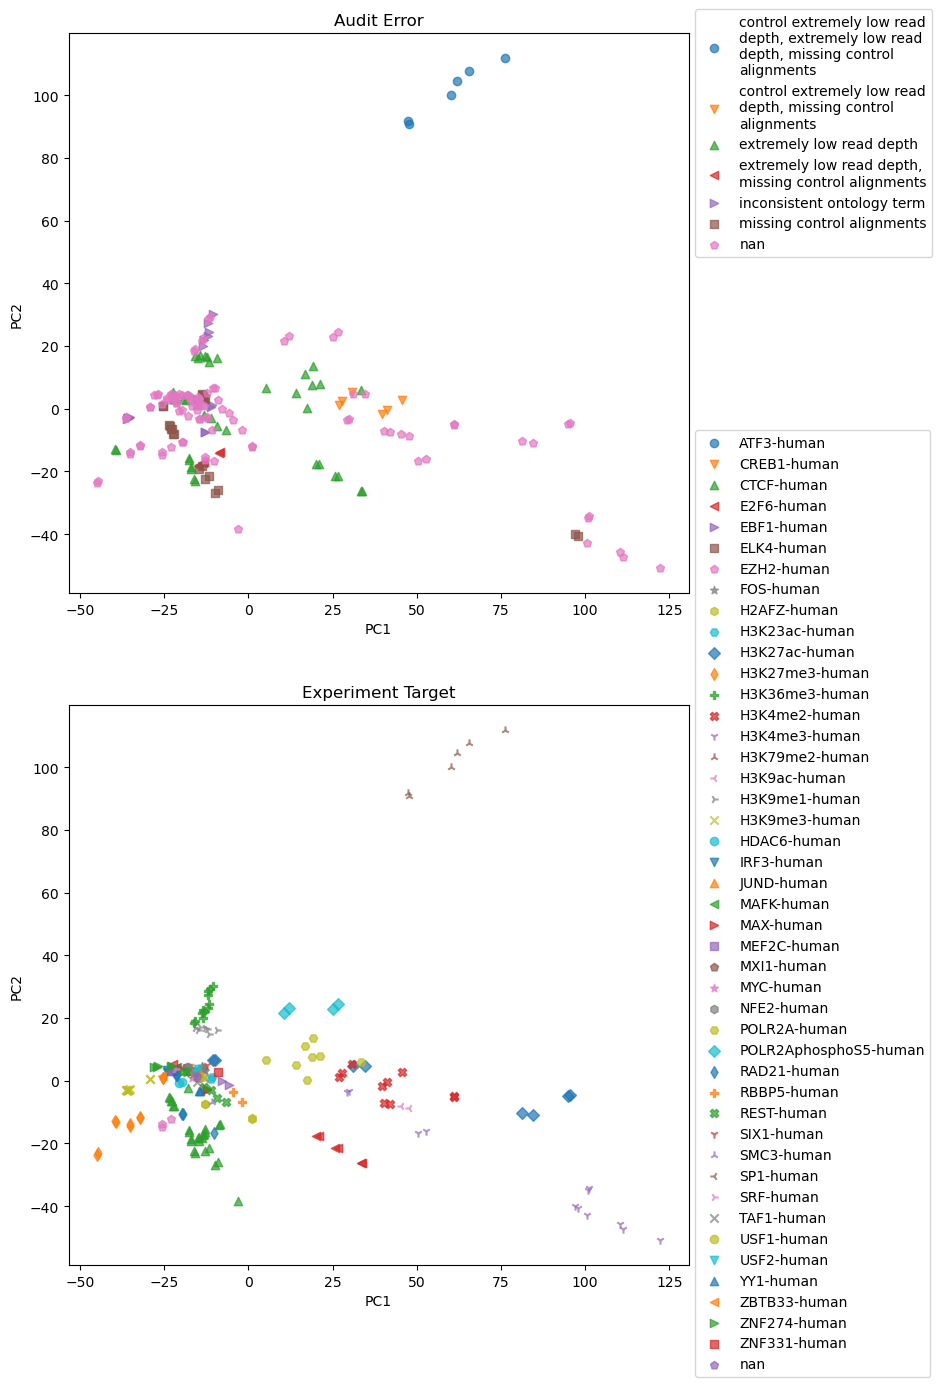

In [5]:
# helper function ===================================================================
"""
    Find the labels for each profile for a column in bigwig_metadata.
    Input:
        col: the name of the column in bigwig_metadata (str)
    Output:
        le: a label encoder for the labels (sklearn.preprocessing._label.LabelEncoder)
        labels: the labels for each profile for a column in bigwig_metadata (list)
"""
def find_labels(col):
    labels = []
    # find the label for each profile for the column
    for profile in profiles:
        labels.append(bigwig_metadata[bigwig_metadata["File accession"] == profile][col].values[0])
    # generate the label encoder
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(labels)
    return le, labels


# data preparation ==================================================================
# find the names of all the columns in bigwig_metadata
cols = bigwig_metadata.columns

# select the two columns "Audit ERROR" and "Experiment target" and get the labels for each profile
# Supplemental part 1 provides the results for other columns
le1, labels1 = find_labels("Audit ERROR")
le2, labels2 = find_labels("Experiment target")

# create a data frame for the PCs and the transformed labels
data = {'PC1': df_signals_t_pca[:, 0], 'PC2': df_signals_t_pca[:, 1], 
        "label1": le1.transform(labels1), "label2": le2.transform(labels2)}
df_label = pd.DataFrame(data = data)



# plotting preparation ================================================================
# as some of the labels for "Audit ERROR" are very long, for better display effects of the graph, 
# wrap these long labels into multiple lines with a maximum length of 30 characters per line
wrapper = textwrap.TextWrapper(width = 30)
new_labels = []
for label in list(le1.classes_):
    new_labels.append(wrapper.fill(label))

# prepare the list of markers for the graphs
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '1', '2', '3', '4', 'x']



# plotting ============================================================================
fig, ax = plt.subplots(2, figsize = (8, 16))

# subplot for "Audit ERROR"
for i in range(le1.classes_.size):
    X = df_label[df_label.label1 == i].iloc[:,0] # PC1
    Y = df_label[df_label.label1 == i].iloc[:,1] # PC2
    ax[0].scatter(X, Y, alpha = 0.7, label = i, marker = markers[i % len(markers)])
    
ax[0].legend(new_labels, loc = (1.01, 0.6))
ax[0].set(xlabel = "PC1", ylabel = "PC2", title = "Audit Error")

# subplot for "Experiment target"
for i in range(le2.classes_.size):
    X = df_label[df_label.label2 == i].iloc[:,0]
    Y = df_label[df_label.label2 == i].iloc[:,1]
    ax[1].scatter(X, Y, alpha = 0.7, label = i, marker = markers[i % len(markers)])
    
ax[1].legend(list(le2.classes_), loc = (1.01, -0.2))
ax[1].set(xlabel = "PC1", ylabel = "PC2", title = "Experiment Target")

plt.show()

<span style='color:Blue'> 
    Column "Audit ERROR" and "Experimental target" seem to be useful for outlier removal. The points with PC2 > 80 (shown above in blue circles in the first subplot for "Audit ERROR" and in brown tri-ups (upside-down "Y"'s) in the second subplot for "Experimental target") are probably outliers, as they are far away from most of the other points. Additionally, according to the information in the column "Audit ERROR", these points have "control extremely low read depth, extremely low read depth, missing control alignments," which represents the most severe errors of all the categories in the column.
</span>

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


/var/folders/gh/wjs3pzl11758g8crdf96rf8c0000gn/T/ipykernel_38813/1575633489.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mpl.cm.ScalarMappable(norm = None, cmap = "viridis"), label = "Autocorrelation with Lag = 1")


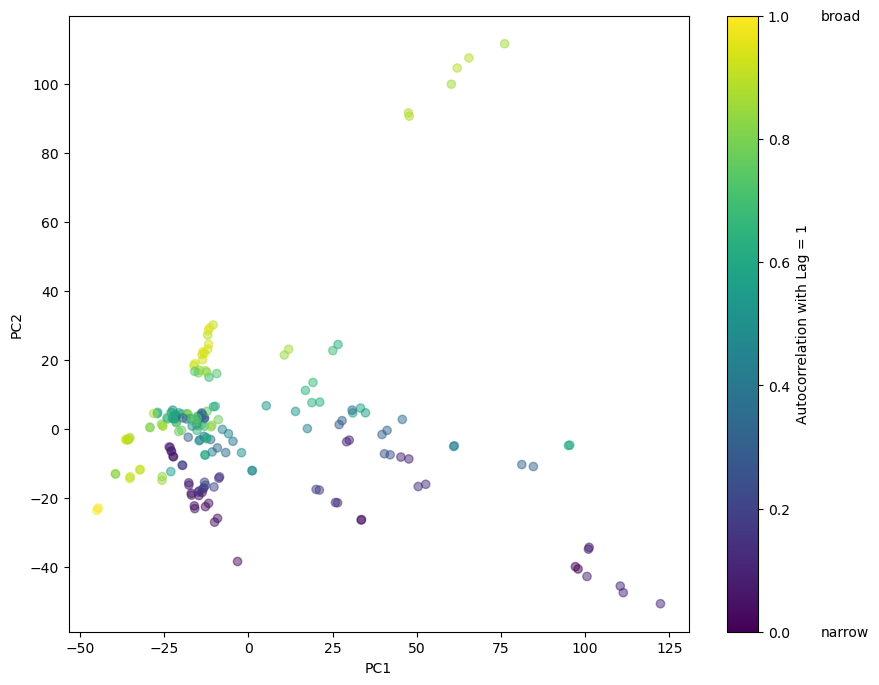

In [6]:
# data preparation ==================================================================
# find the labels for "Assay", "Experiment target", "Biosample term name"
le_assay, labels_assay = find_labels("Assay")
le_expt_tar, labels_expt_tar = find_labels("Experiment target")
le_term, labels_term = find_labels("Biosample term name")

# transform the labels from text strings to categories
assay_index = le_assay.transform(labels_assay)
expt_tar_index = le_expt_tar.transform(labels_expt_tar)
term_index = le_term.transform(labels_term)

# create a data frame for the PCs, labels, and their categories
data = {'PC1': df_signals_t_pca[:, 0], 'PC2': df_signals_t_pca[:, 1], 
        "assay": labels_assay, "assay_index": assay_index,
        "expt_tar": labels_expt_tar, "expt_tar_index": expt_tar_index,
        "term": labels_term, "term_index": term_index}
df_label = pd.DataFrame(data = data)



# calculating autocorrelation ========================================================
# focus on autocorrelation with lag = 1
autocorrelation_lag_1 = []

for i in range(df_label.shape[0]):
    # get the data for profile of index [i]
    data_i = df_signals.iloc[:, i]
    # shift the values by 1
    data_i_lag = data_i.shift(1)
    # concatenate the original values and the shifted values into one data frame
    df_i = pd.concat([data_i_lag, data_i], axis = 1)
    df_i.columns = ['p', 'p + 1']
    # calculate the correlation between 'p' and 'p + 1' (autocorrelation with lag = 1)
    result_i = df_i.corr().iloc[0, 1]
    autocorrelation_lag_1.append(result_i)



# plotting ============================================================================
fig, ax = plt.subplots(figsize = (10, 8))

# color the dots based on autocorrelation
ax.scatter(df_label.iloc[:, 0], df_label.iloc[:, 1], alpha = 0.5, 
           c = autocorrelation_lag_1, cmap = "viridis")
ax.set(xlabel = "PC1", ylabel = "PC2")

# add the text boxes to indicate the relationship between autocorrelation and broad vs narrow patterns 
ax.text(170, 118.5, "broad")
ax.text(170, -60, "narrow")
fig.colorbar(mpl.cm.ScalarMappable(norm = None, cmap = "viridis"), label = "Autocorrelation with Lag = 1") 

plt.show()

<span style='color:Blue'> 
    ATAC-seq shows a narrow pattern (low autocorrelation), while the Assays for TF ChIP-seq and Histone ChIP-seq show broad patterns (high autocorrelation) and narrow patterns across different biosample term names. (See Supplemental Part 2 for the graph.)
</span>
<br>
<br>
<span style='color:Blue'>     
    Experiment Targets such as H3K27me3-human and H3K36me3-human show broad patterns, and the broad pattern is consistent across cell types. Experiment Targets such as CTCF-human and H3K4me3-human show narrow patterns, and the narrow pattern is consistent across cell types. However, there are also Experiment Targets that display different patterns across different cell types, such as E2F6-human and RAD21-human. (See Supplemental Part 3 for the graph.)
</span>
<br>
<br>
<span style='color:Blue'>     
    In the graph above, the colors of the points correspond to the autocorrelations of each profile with $lag = 1$. The data points showing broad patterns in general have highly negative PC1 and PC2 values or highly positive PC2 values, whereas the points showing narrow patterns in general have highly negative PC2 values and less negative or even positive PC1 values. (Supplemental Part 4 shows the PCA overlaid with assay (or experiment target) and biosample term name, which, together with the graph above, further supports Supplemental Part 2 and 3.)
</span>

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


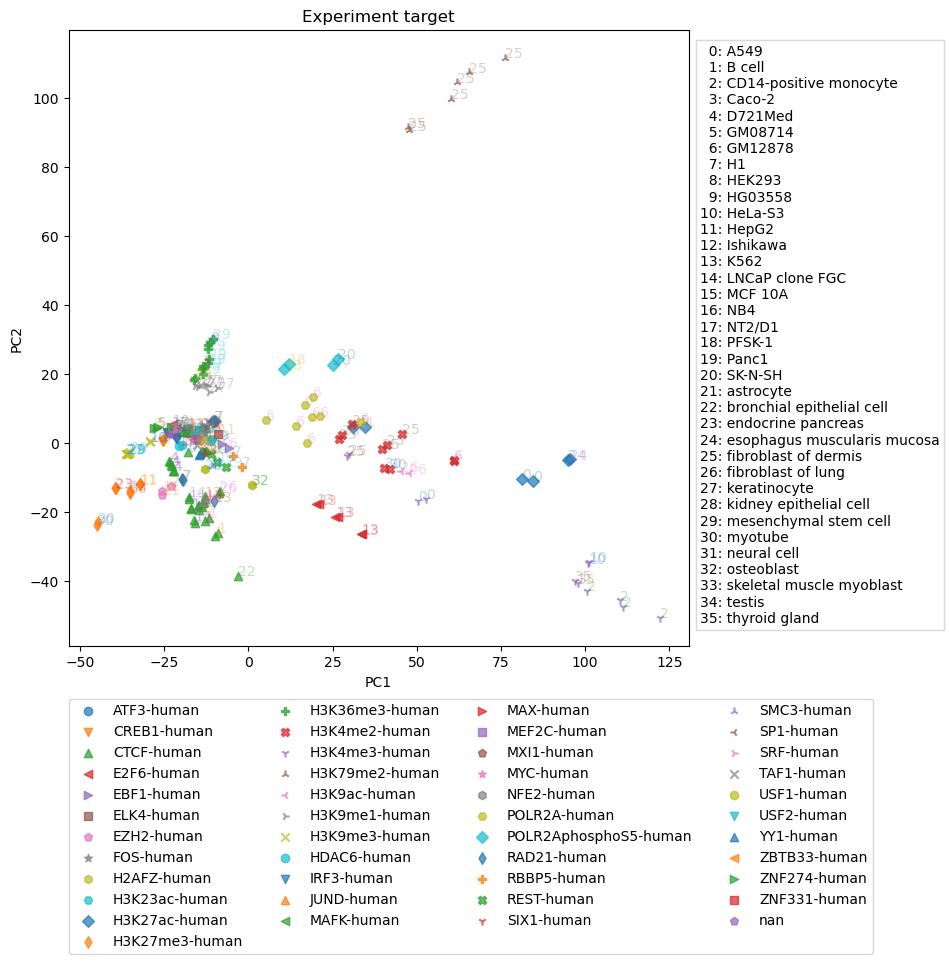

,PC1,PC2,assay,assay_index,expt_tar,expt_tar_index,term,term_index,term_color
4,-25.662174,-14.881949,TF ChIP-seq,2,EZH2-human,6,HepG2,11,#ff7f0e
48,-8.947831,2.691750,TF ChIP-seq,2,ZNF331-human,43,HepG2,11,#ff7f0e
50,-20.715987,4.691796,TF ChIP-seq,2,SP1-human,35,HepG2,11,#ff7f0e
64,-32.171632,-11.729138,Histone ChIP-seq,1,H3K27me3-human,11,HepG2,11,#ff7f0e
70,-19.764523,4.343019,TF ChIP-seq,2,SP1-human,35,HepG2,11,#ff7f0e
131,-17.782482,3.977968,TF ChIP-seq,2,CREB1-human,1,HepG2,11,#ff7f0e
141,-14.997890,0.953594,TF ChIP-seq,2,MXI1-human,25,HepG2,11,#ff7f0e
148,-32.257978,-11.918108,Histone ChIP-seq,1,H3K27me3-human,11,HepG2,11,#ff7f0e
162,-12.457645,-2.525695,TF ChIP-seq,2,MAX-human,23,HepG2,11,#ff7f0e
175,-12.430910,-2.829402,TF ChIP-seq,2,MAX-human,23,HepG2,11,#ff7f0e


In [7]:
# data preparation ==================================================================
# the same data as in question 4
data = {'PC1': df_signals_t_pca[:, 0], 'PC2': df_signals_t_pca[:, 1], 
        "assay": labels_assay, "assay_index": assay_index,
        "expt_tar": labels_expt_tar, "expt_tar_index": expt_tar_index,
        "term": labels_term, "term_index": term_index}
df_label = pd.DataFrame(data = data)



# plotting preparation ================================================================
# generate a multi-line string for the column "Biosample term name" such that:
# each line has the form "[i]: [term_name]"
text = ""

for i, term in enumerate(le_term.classes_):
    # add extra blankspaces in front of the indices less than 10 so that the colons align with each other
    if i < 10:
        text = text + "  "
    # the content of line [i]
    text = text + str(i) + ": " + term
    # enter a new line if this is not the last line
    if i != le_term.classes_.size - 1:
        text = text + "\n"
        
# create a list of colors for overlaying labels of biosample term names
palette = mcolors.TABLEAU_COLORS
colors = []
for i in palette:
    colors.append(palette[i])
# create a list of colors for each profile based on biosample term names
term_color = list(map(lambda x: colors[x % len(colors)], term_index))
df_label["term_color"] = term_color



# plotting ============================================================================
fig, ax = plt.subplots(figsize = (8, 8))

for i in range(le_expt_tar.classes_.size):
    X = df_label[df_label.expt_tar_index == i].iloc[:,0]
    Y = df_label[df_label.expt_tar_index == i].iloc[:,1]
    ax.scatter(X, Y, alpha = 0.7, label = i, marker = markers[i % len(markers)])

# overlay the labels of biosample term names
for i in range(df_label.shape[0]):
    ax.text(df_label.iloc[i, 0], df_label.iloc[i, 1], df_label.iloc[i, 7], 
            c = df_label.iloc[i, 8], alpha = 0.3)
    
ax.legend(list(le_expt_tar.classes_), loc = (0, -0.5), ncols = 4)
ax.set(xlabel = "PC1", ylabel = "PC2", title = "Experiment target")

# create a text box for the categories of "Biosample term name"
ax.text(134, -52, text, bbox = dict(boxstyle = "square", ec = (0.85, 0.85, 0.85), fc = (1, 1, 1)))

plt.show()



# results for proximity of EZH2-human and H3K27me3-human in HepG2 ======================
df_label[df_label.term_index == 11]

<span style='color:Blue'> 
    As the graph above indicates, EZH2-human (transcription factor) and H3K27me3-human (histone marks) in HepG2 (biosample term name) are nearby in this PC1 vs PC2 space, with the data points for EZH2-human represented as pink pentagons (near (-25, -15)) and the data points for H3K27me3-human represented as orange thin diamonds (around (-35, -15)). Biosample term name HepG2 refers to the points overlaid with label 11. The proximity of EZH2-human and H3K27me3-human has plausible biological interpretations, since in mammals, EZ homolog 2 (EZH2) is recruited to H3K27 for methylation of H3K27, and EZH2, which is a component of polycomb repression complex PRC2, imposes high levels of H3K27me3. (Golbabapour et al., 2013)
</span>
<br>
<br>
<span style='color:Blue'> 
    References: 
</span>
<br>
<span style='color:Blue'> 
    Golbabapour S, Majid NA, Hassandarvish P, Hajrezaie M, Abdulla MA, Hadi AH. Gene silencing and Polycomb group proteins: an overview of their structure, mechanisms and phylogenetics. OMICS. 2013 Jun;17(6):283-96. doi: 10.1089/omi.2012.0105. PMID: 23692361; PMCID: PMC3662373.
</span>

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


/var/folders/gh/wjs3pzl11758g8crdf96rf8c0000gn/T/ipykernel_38813/2868880782.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mpl.cm.ScalarMappable(norm = None, cmap = "viridis"), label = "Autocorrelation with Lag = 1")


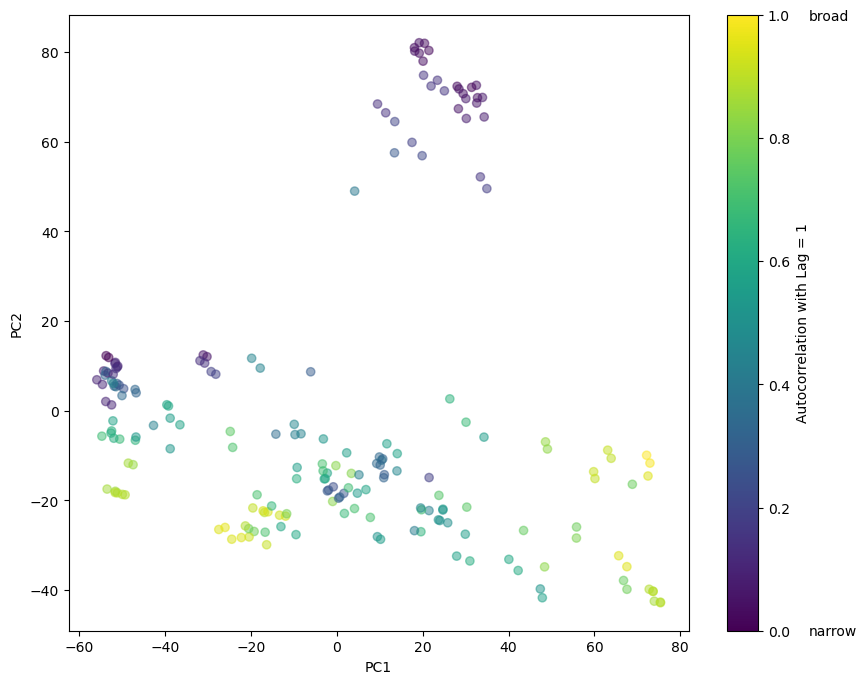

In [8]:
# data preparation ==================================================================
# remove the region on chr10 near the centromere (here chosen to be between 40 Mb and 41.5 Mb)
df_clean = df[(df["start"] < 40000000) | (df["start"] > 41500000)]
# the colomns that need to be removed are the first three: "chrom", "start", and "end"
df_clean_signals = df_clean.iloc[:, 3:]

# normalize the variance per track
scaler = StandardScaler().fit(df_clean_signals)
df_scaled = scaler.transform(df_clean_signals)
# transpose the data so that the PCA is performed on the profile rather than the bins (positions)
df_scaled_t = df_scaled.T

# perform PCA
pca = PCA(n_components = 2)
df_scaled_t_pca = pca.fit_transform(df_scaled_t)

# create a data frame for the PCs, labels, and their categories
data = {'PC1': df_scaled_t_pca[:, 0], 'PC2': df_scaled_t_pca[:, 1], 
        "assay": labels_assay, "assay_index": assay_index,
        "expt_tar": labels_expt_tar, "expt_tar_index": expt_tar_index,
        "term": labels_term, "term_index": term_index}
df_label_scaled = pd.DataFrame(data = data)



# calculating autocorrelation ========================================================
# focus on autocorrelation with lag = 1
autocorrelation_lag_1 = []

for i in range(df_label.shape[0]):
    # create a data frame for profile of index [i]
    data_i = pd.DataFrame(data = df_scaled[:, i])
    # shift the values by 1
    data_i_lag = data_i.shift(1)
    # concatenate the original values and the shifted values into one data frame
    df_i = pd.concat([data_i_lag, data_i], axis = 1)
    df_i.columns = ['p', 'p + 1']
    # calculate the correlation between 'p' and 'p + 1' (autocorrelation with lag = 1)
    result_i = df_i.corr().iloc[0, 1]
    autocorrelation_lag_1.append(result_i)



# plotting ============================================================================
fig, ax = plt.subplots(figsize = (10, 8))

# color the dots based on autocorrelation
ax.scatter(df_label_scaled.iloc[:, 0], df_label_scaled.iloc[:, 1], alpha = 0.5, 
           c = autocorrelation_lag_1, cmap = "viridis")
ax.set(xlabel = "PC1", ylabel = "PC2")

# add the text boxes to indicate the relationship between autocorrelation and broad vs narrow patterns 
ax.text(110, 87, "broad")
ax.text(110, -50, "narrow")
fig.colorbar(mpl.cm.ScalarMappable(norm = None, cmap = "viridis"), label = "Autocorrelation with Lag = 1") 

plt.show()

<span style='color:Blue'> 
     Preprocessing matters to some extent. As the PCA graph above shows, the positions of the data points as well as the spatial relationships between points differ before and after preprocessing. As the graph in question 4 shows, the group of points that seem to be outliers (with PC2 > 80 and in lime color) have high autocorrelations and broad patterns. However, after preprocessing the data, the group of points that are distant from most of the other points in the new PC1 vs PC2 space (the points with PC2 > 40 and in blue/purple color) have very low autocorrelations and thus narrow patterns.
</span>
<br>
<br>
<span style='color:Blue'> 
    Nonetheless, as the graph in Supplemental Part 5 shows, EZH2-human (transcription factor) and H3K27me3-human (histone marks) in HepG2 (biosample term name) are still nearby in this new PC1 vs PC2 space, with the data points for EZH2-human represented as pink pentagons (near (50, -10)) and the data points for H3K27me3-human represented as orange thin diamonds (around (60, -15)). Biosample term name HepG2 refers to the points overlaid with label 11. 
</span>

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


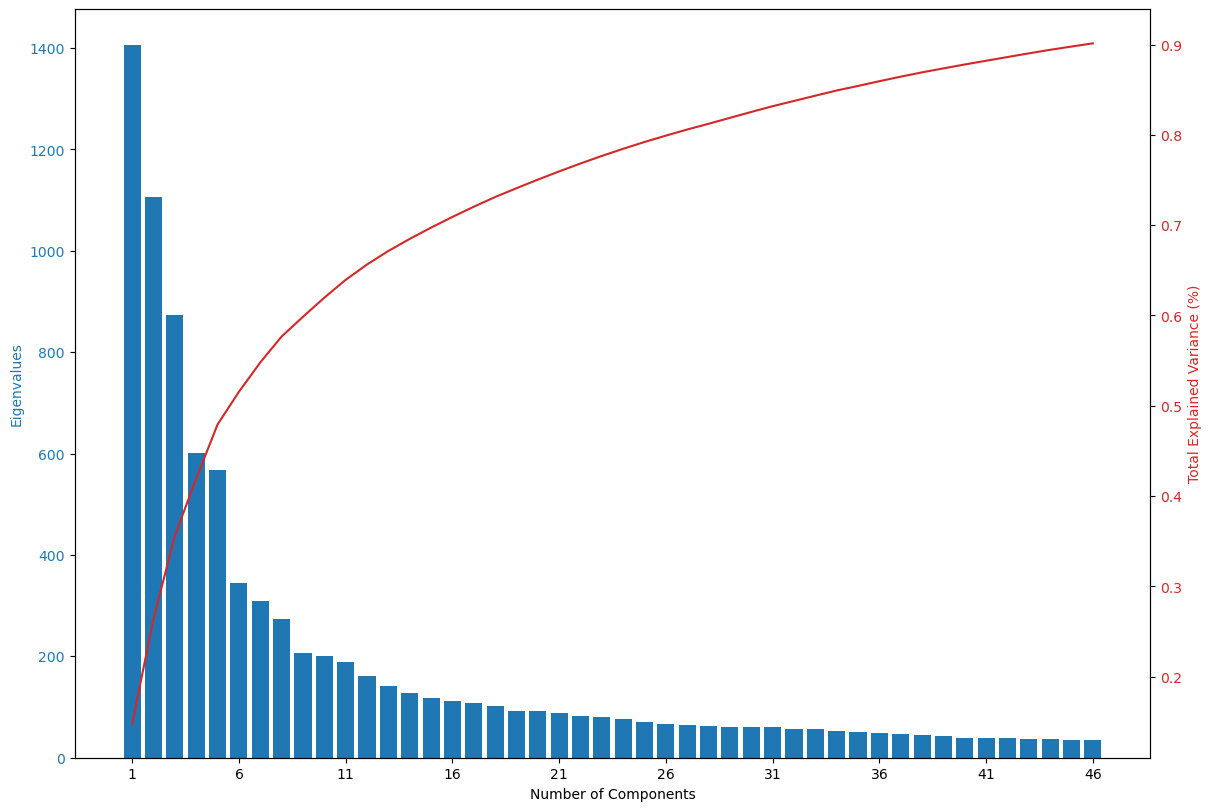

In [9]:
# perform PCA ======================================================================== 
n_components = 1
pca = PCA(n_components)
pca.fit(df_scaled_t)
# maintain a list of the total percentage of explained variance of the PCs
explained = [np.sum(pca.explained_variance_ratio_)]
# iterate until the total percentage of explained variance of the PCs is at least 90%
while explained[-1] < 0.90:
    n_components += 1
    pca = PCA(n_components)
    pca.fit(df_scaled_t)
    explained.append(np.sum(pca.explained_variance_ratio_))



# plotting ============================================================================
X = np.arange(1, n_components + 1) 

fig, ax1 = plt.subplots(figsize = (12, 8), constrained_layout = True)
color = 'tab:blue'
# draw the bars, each representing the eigenvalue (explained variance) for each single PC
ax1.bar(X, pca.explained_variance_, color = color)
ax1.set(xlabel = "Number of Components", xticks = list(np.arange(1, n_components + 1, 5)))
ax1.set_ylabel("Eigenvalues", color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()
color = 'tab:red'
# draw the line for the cumulative explained variances
ax2.plot(X, explained, color = color)
ax2.set_ylabel('Total Explained Variance (%)', color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.show()

<span style='color:Blue'> 
    46 PCs are needed to to explain 90% of the variance in the data.
</span>

- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


/Users/wangqifan/anaconda3/envs/qbio577/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


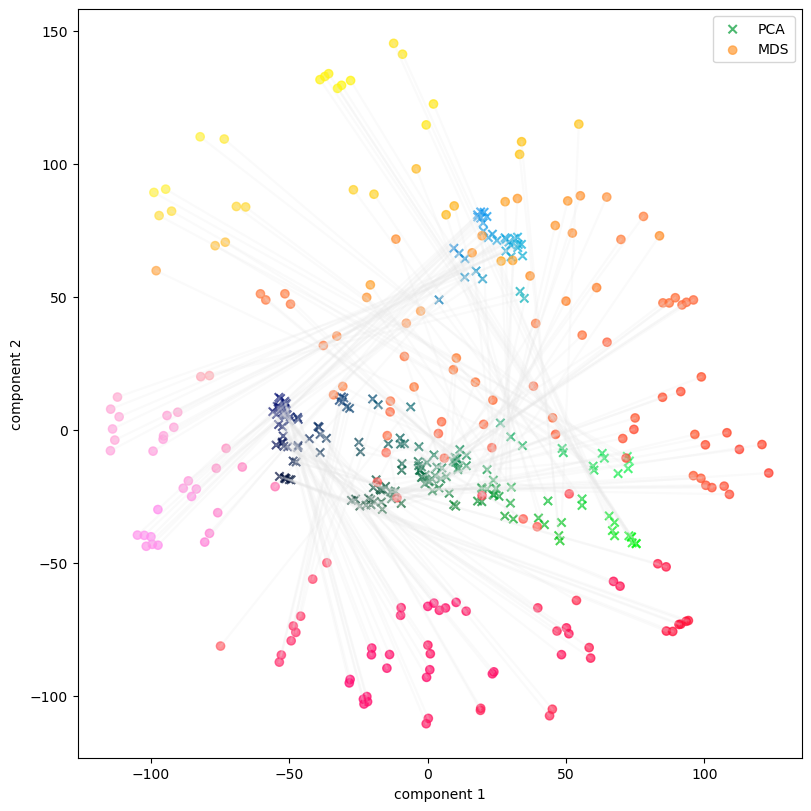

In [10]:
# perform MDS ========================================================================
# set random seed, maximum time of iterations, as well as the number of times 
# the algorithm is run with different initializations
md_scaling = manifold.MDS(n_components = 2, random_state = 97, 
                          max_iter = 500000, n_init = 100)
data_scaling = md_scaling.fit_transform(df_scaled_t)



# plotting preparation ================================================================
# PC1 of the preprocessed data
X = df_scaled_t_pca[:, 0]
# PC2 of the preprocessed data
Y = df_scaled_t_pca[:, 1]
# create a list of greenness based on PC1
G = (X + 60) / 140
# create a list of blueness based on PC2
B = (Y + 50) / 140
# create a list of RGB colors for display of the PCA results
C1 = []
# create a list of RGB colors for display of the MDS results
C2 = []
for i in range(X.shape[0]):
    # for PCA results, use R = 0
    C1.append((0, G[i], B[i]))
    # for MDS results, use R = 1
    C2.append((1, G[i], B[i]))
C1 = np.array(C1)
C2 = np.array(C2)



# plotting ============================================================================
fig, ax = plt.subplots(figsize = (8, 8), constrained_layout = True)

for i in range(X.shape[0]):
    # use grey lines to connect the positions of each data point in the PC1 vs PC2 plane
    # and in the MDS1 and MDS2 plane
    ax.plot([df_scaled_t_pca[i, 0], data_scaling[i, 0]], 
            [df_scaled_t_pca[i, 1], data_scaling[i, 1]], 
            alpha = 0.2, c = "0.9")
    
# scatter plot with PCA results
ax.scatter(df_scaled_t_pca[:, 0], df_scaled_t_pca[:, 1], alpha = 0.7, c = C1, marker = "x", label = "PCA")
ax.set(xlabel = "component 1", ylabel = "component 2")

# scatter plot with MDS results
ax.scatter(data_scaling[:, 0], data_scaling[:, 1], alpha = 0.7, c = C2, marker = "o", label = "MDS")
ax.legend()

plt.show()

<span style='color:Blue'> 
    The dimensionality reduction into two dimensions for PCA is different from that obtained using MDS. From the graph above, we see that the data points are more scattered across the plane consisting of the first two components for MDS than for PCA. The average distance between the positions of each data point on the plane consisting of the first two components for MDS and for PCA is also large. However, points that are close to each other in the plane consisting of the first two components for PCA also tend to be close to each other in the plane consisting of the first two components for MDS. For instance, the light green points in PCA correspond to the yellow points in MDS; the dark green points in PCA correspond to the orange points in MDS; the light blue points in PCA correspond to the pink points in MDS; and the dark blue points in PCA correspond to the red points in MDS.
</span>

- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


In [11]:
# calculate the number of negative entries in the data frame
n_negative = int(df_clean_signals.where(df_clean_signals >= 0).isna().sum().sum())
print("The number negative entries in the data is: %i." % n_negative)

The number negative entries in the data is: 0.


<span style='color:Blue'> 
    Non-negative matrix factorization would be a useful method to use for this dataset. First of all, all the entries in the dataset are non-negative, which means that the prerequisite for using non-negative matrix factorization is satisfied. Furthermore, PCA can give rise to components containing negative values, which makes the interpretation of the PCA results impossible, whereas non-negative matrix factorization preserves the non-negativity of the data (neither W nor H contains negative entries), which makes the interpretation of the results easier.
</span>

### Supplemental Parts

#### Supplemental Part 1: PCA overlaid with categories of all useful columns in bigwig_metadata

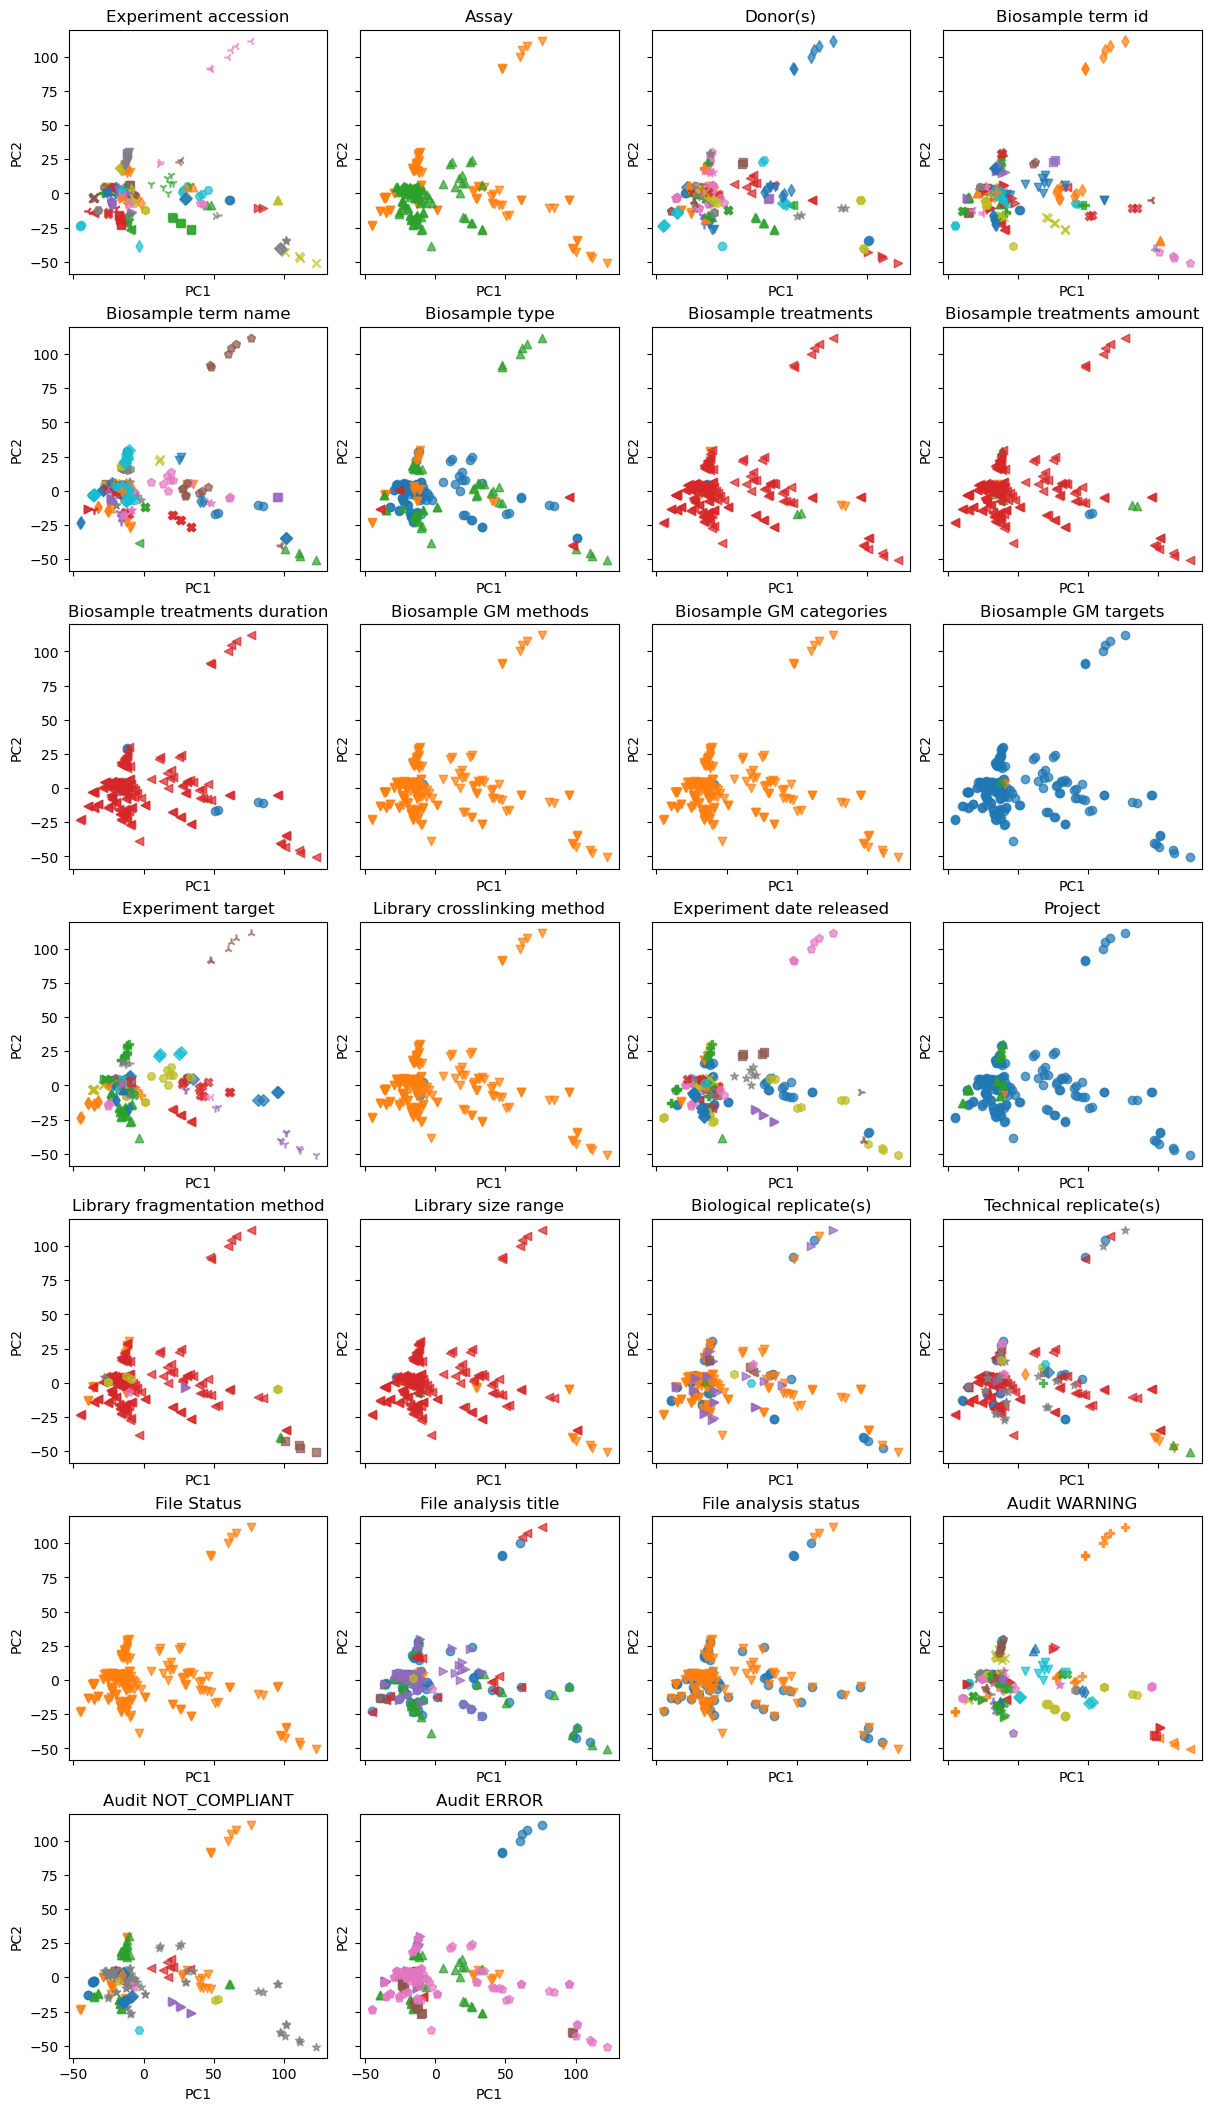

In [12]:
# data preparation ==================================================================
# find the potentially useful columns with the following criteria:
# 1. the 200 profiles should fall into more than one categories of the column.
# 2. the 200 profiles should not all fall into different categories of the column.
useful_cols = []
n_profiles = profiles.shape[0]
for i, col in enumerate(cols):
    # find the labels for each profile for the column
    le_i, labels_i = find_labels(col)
    n_classes = le_i.classes_.size
    # check if the criteria applies
    if n_classes > 1 and n_classes < n_profiles:
        useful_cols.append(col)

        
        
# plotting ============================================================================
fig, axs = plt.subplots(7, 4, figsize = (12, 21), sharex = True, sharey = True, constrained_layout = True)

# subplot for each of the potentially useful columns
for i, col in enumerate(useful_cols):
    # get the labels
    le_i, labels_i = find_labels(col)
    
    # create a data frame for the PCs and the label
    data_i = {'PC1': df_signals_t_pca[:, 0], 'PC2': df_signals_t_pca[:, 1], "label": le_i.transform(labels_i)}
    df_label_i = pd.DataFrame(data = data_i)
    
    # get the row and column of the subplot
    row_i = i // 4
    col_i = i % 4
    
    # plot iteratively for each category of the column
    for j in range(le_i.classes_.size):
        X = df_label_i[df_label_i.label == j].iloc[:,0] # PC1
        Y = df_label_i[df_label_i.label == j].iloc[:,1] # PC2
        axs[row_i, col_i].scatter(X, Y, alpha = 0.7, label = j, marker = markers[j % len(markers)])
    
    # as some of the names of the columns are long, shorten them to improve display effect
    title = col.replace('genetic modifications', "GM") if 'genetic modifications' in col else col
    axs[row_i, col_i].set(xlabel = "PC1", ylabel = "PC2", title = title)

# delete the last two blank plots
fig.delaxes(axs[6, 2])
fig.delaxes(axs[6, 3])

plt.show()

#### Supplemental Part 2: Autocorrelation graphs with respect to assay

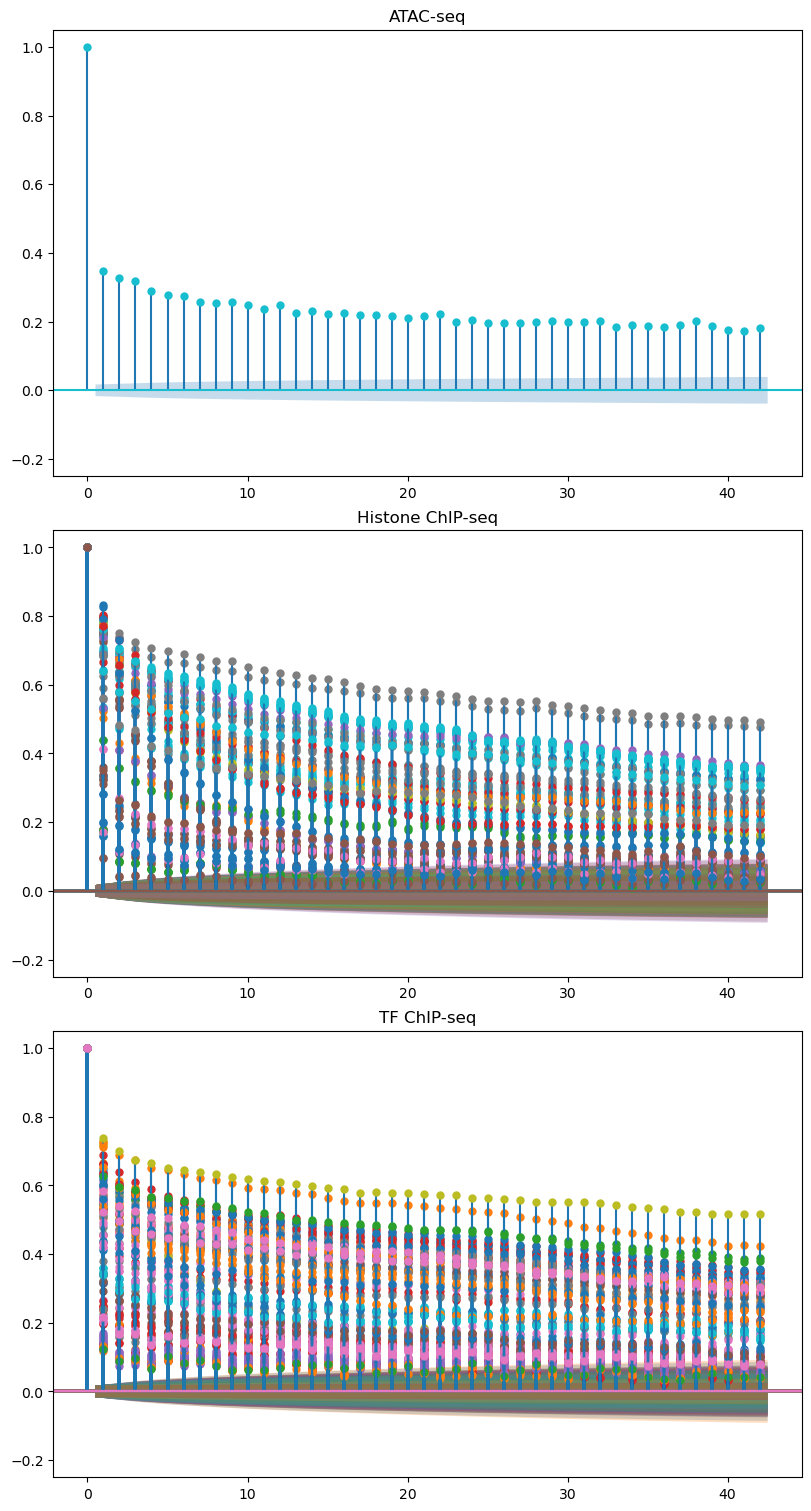

In [13]:
# data preparation ==================================================================
# the same data as in question 4
data = {'PC1': df_signals_t_pca[:, 0], 'PC2': df_signals_t_pca[:, 1], 
        "assay": labels_assay, "assay_index": assay_index,
        "expt_tar": labels_expt_tar, "expt_tar_index": expt_tar_index,
        "term": labels_term, "term_index": term_index}
df_label = pd.DataFrame(data = data)



# plotting preparation ================================================================
# create a list of colors for overlaying labels of biosample term names
palette = mcolors.TABLEAU_COLORS
colors = []
for i in palette:
    colors.append(palette[i])
# create a list of colors for each profile based on biosample term names
term_color = list(map(lambda x: colors[x % len(colors)], term_index))
df_label["term_color"] = term_color


# plotting ============================================================================
fig, axs = plt.subplots(3, figsize = (8, 15), constrained_layout = True)
for i in range(df_label.shape[0]):
    # get the data for the profile needed
    data_i = df_signals.iloc[:, i]
    # get the row (subplot) needed based on assay_index
    row_i = df_label.iloc[i, 3]
    # get the color needed based on the biosample term name (term_color)
    color_i = df_label.iloc[i, 8]
    # plot the autocorrelation function as a function of lag
    plot_acf(data_i, ax = axs[row_i], c = color_i)
for i in range(3):
    axs[i].set(title = list(le_assay.classes_)[i], ybound = (-0.25, 1.05))

plt.show()

#### Supplemental Part 3: Autocorrelation graphs with respect to experiment target

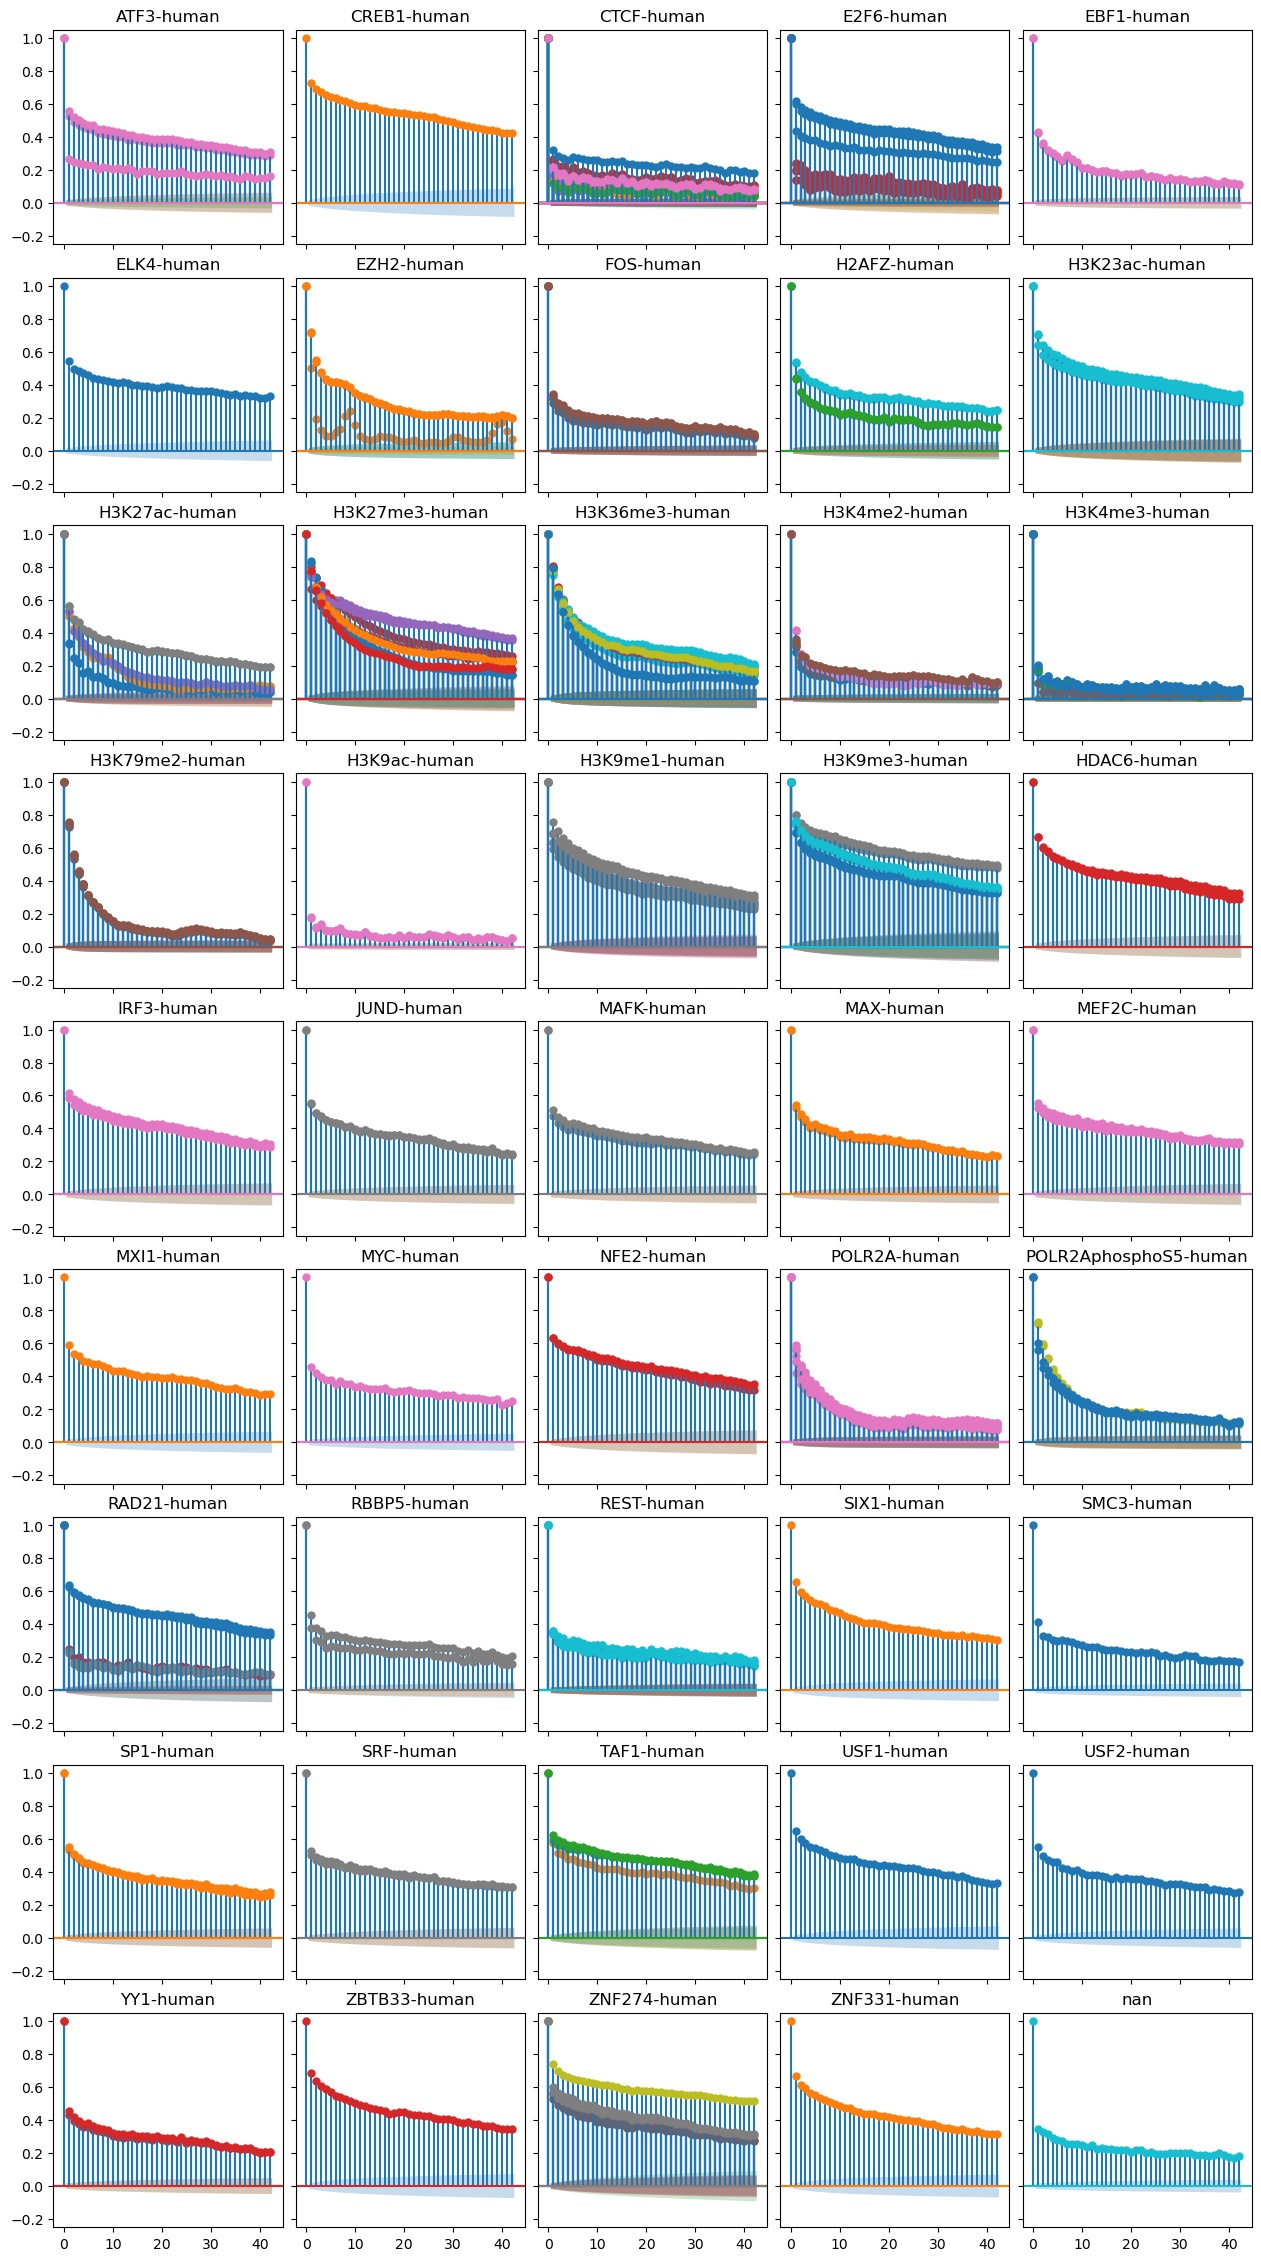

In [14]:
# plotting ============================================================================
fig, axs = plt.subplots(9, 5, figsize = (12.5, 22.5), sharex = True, sharey = True, constrained_layout=True)
for i in range(df_label.shape[0]):
    # get the data for the profile needed
    data_i = df_signals.iloc[:, i]
    # get the expt_tar_index 
    id_i = df_label.iloc[i, 5]
    # get the row of the subplot
    row_i = id_i // 5
    # get the column of the subplot
    col_i = id_i % 5
    # get the color needed based on the biosample term name (term_color)
    color_i = df_label.iloc[i, 8]
    # plot the autocorrelation function as a function of lag
    plot_acf(data_i, ax = axs[row_i, col_i], c = color_i)
for i in range(9):
    for j in range(5):
        axs[i, j].set(ybound = (-0.25, 1.05), title = list(le_expt_tar.classes_)[i * 5 + j])

plt.show()

#### Supplemental Part 4: PCA overlaid with assay (or experiment target) and biosample term name

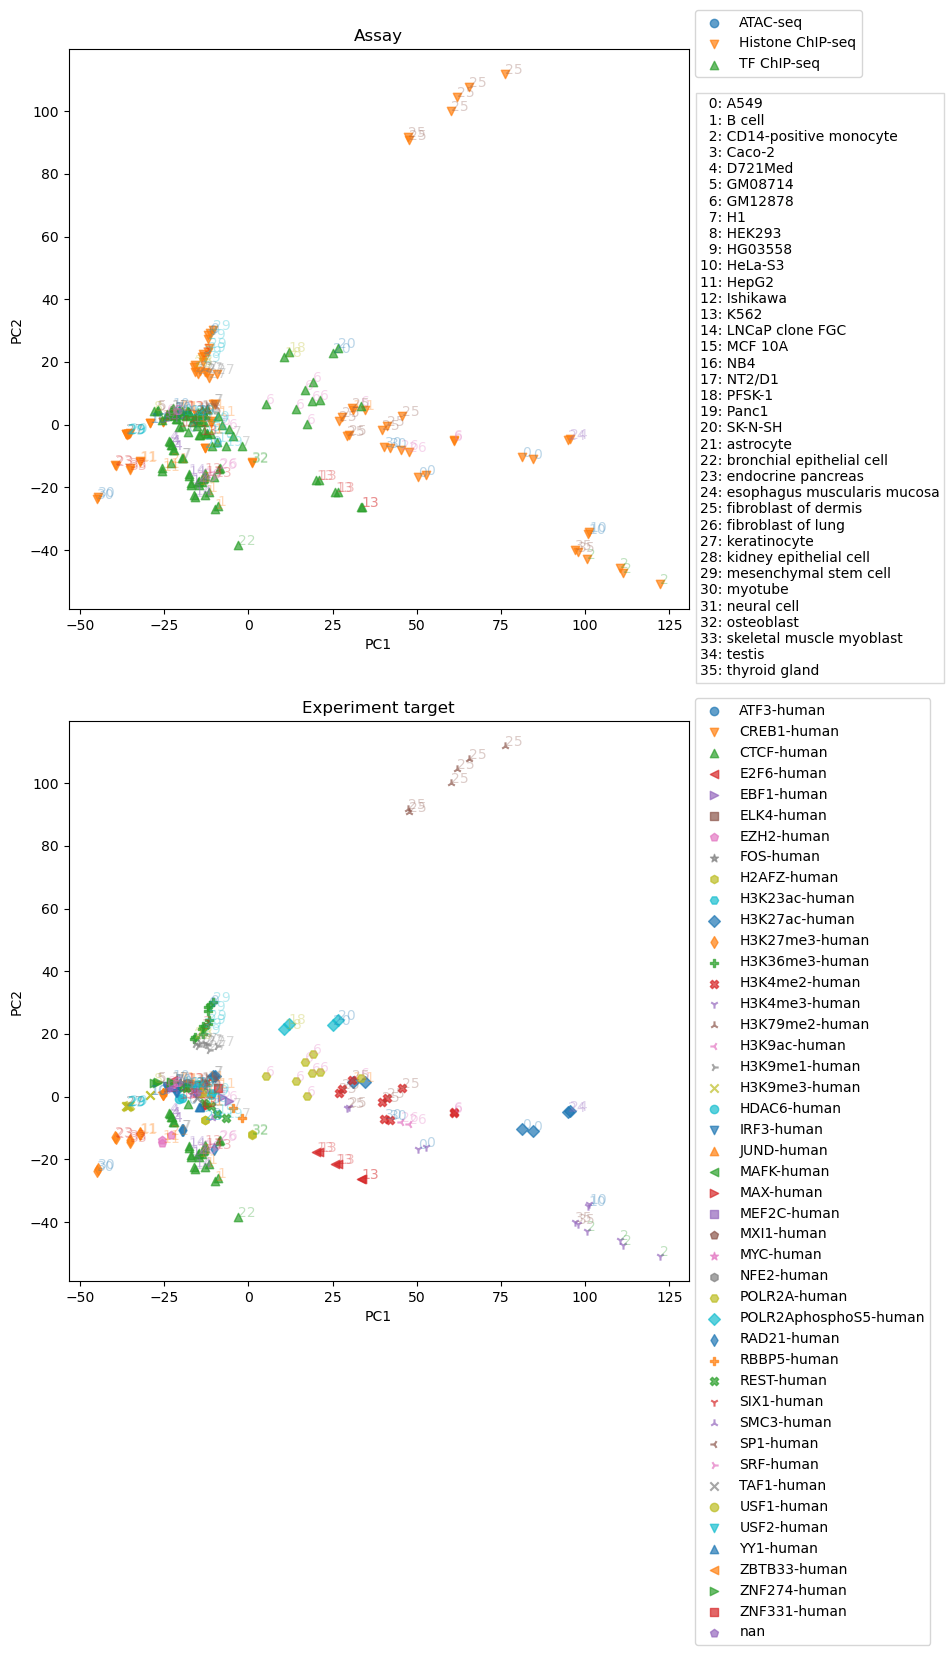

In [15]:
# plotting preparation ================================================================
# generate a multi-line string for the column "Biosample term name" such that:
# each line has the form "[i]: [term_name]"
text = ""

for i, term in enumerate(le_term.classes_):
    # add extra blankspaces in front of the indices less than 10 so that the colons align with each other
    if i < 10:
        text = text + "  "
    # the content of line [i]
    text = text + str(i) + ": " + term
    # enter a new line if this is not the last line
    if i != le_term.classes_.size - 1:
        text = text + "\n"

        

# plotting ============================================================================
fig, axs = plt.subplots(2, figsize = (8, 16))

# subplot for "Assay"
for i in range(le_assay.classes_.size):
    X = df_label[df_label.assay_index == i].iloc[:,0]
    Y = df_label[df_label.assay_index == i].iloc[:,1]
    axs[0].scatter(X, Y, alpha = 0.7, label = i, marker = markers[i % len(markers)])

# overlay the labels of biosample term names
for i in range(df_label.shape[0]):
    axs[0].text(df_label.iloc[i, 0], df_label.iloc[i, 1], df_label.iloc[i, 7], 
                c = df_label.iloc[i, 8], alpha = 0.3)
    
axs[0].set(xlabel = "PC1", ylabel = "PC2", title = "Assay")
axs[0].legend(list(le_assay.classes_), loc = (1.01, 0.95))

# create a text box for the categories of "Biosample term name"
axs[0].text(134, -80, text, bbox = dict(boxstyle = "square", ec = (0.85, 0.85, 0.85), fc = (1, 1, 1)))

# subplot for "Experimental target"
for i in range(le_expt_tar.classes_.size):
    X = df_label[df_label.expt_tar_index == i].iloc[:,0]
    Y = df_label[df_label.expt_tar_index == i].iloc[:,1]
    axs[1].scatter(X, Y, alpha = 0.7, label = i, marker = markers[i % len(markers)])

# overlay the labels of biosample term names
for i in range(df_label.shape[0]):
    axs[1].text(df_label.iloc[i, 0], df_label.iloc[i, 1], df_label.iloc[i, 7], 
                c = df_label.iloc[i, 8], alpha = 0.3)

axs[1].set(xlabel = "PC1", ylabel = "PC2", title = "Experiment target")
axs[1].legend(list(le_expt_tar.classes_), loc = (1.01, -0.65))

plt.show()

#### Supplemental Part 5: PCA overlaid with assay (or experiment target) and biosample term name (with preprocessing)

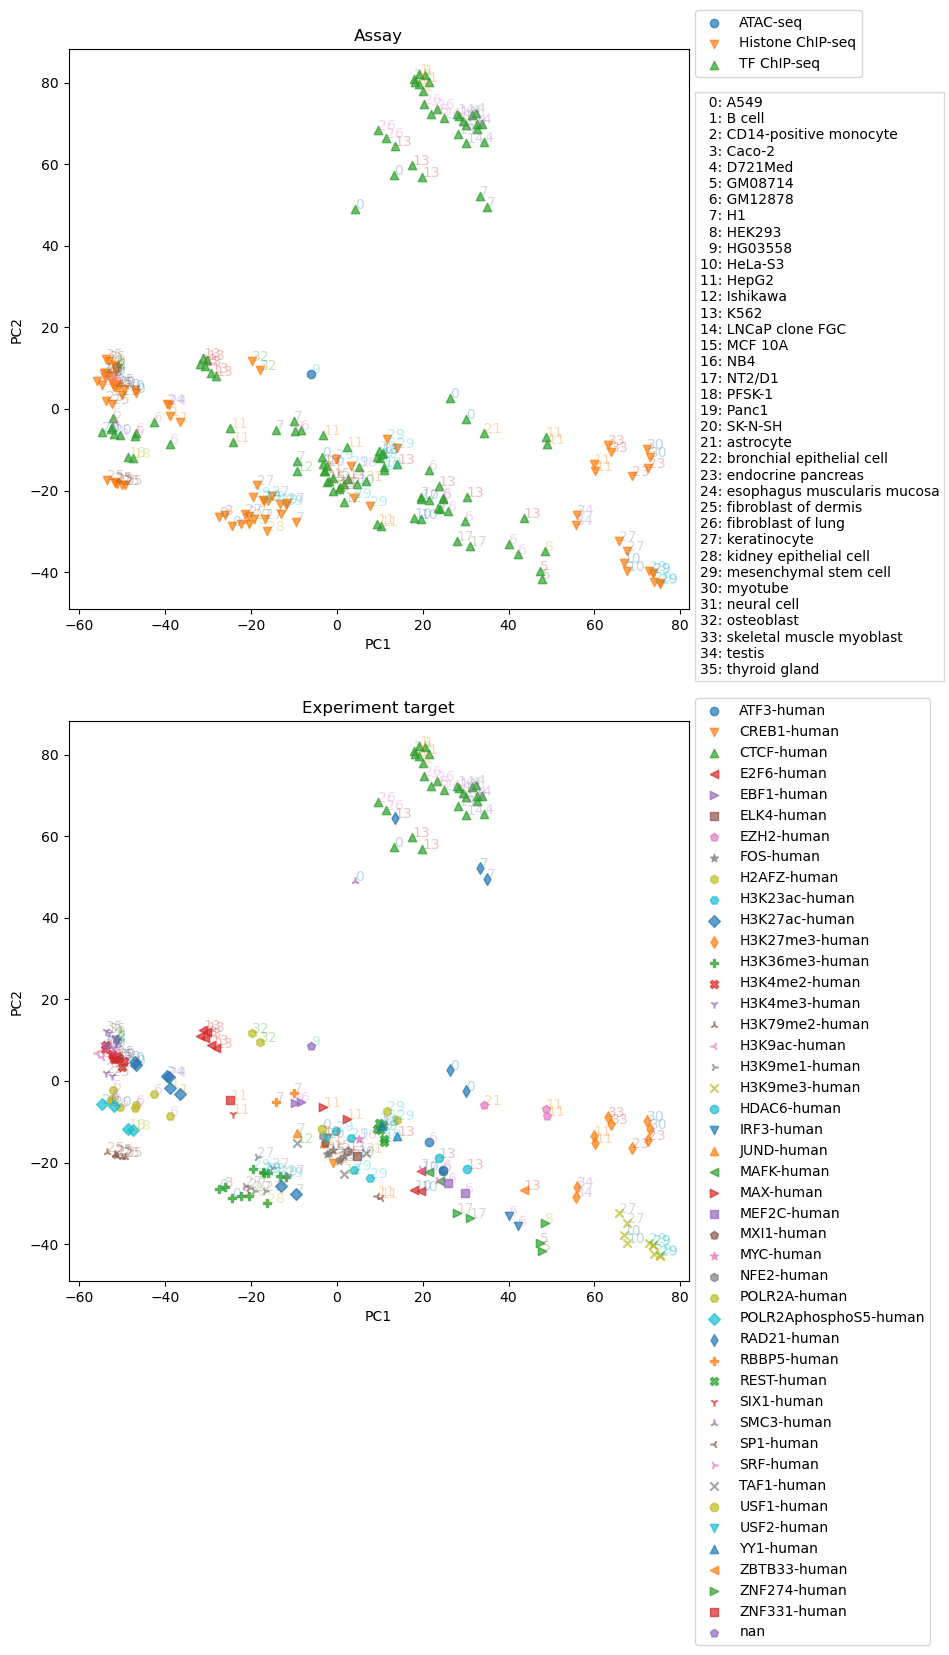

In [17]:
# plotting preparation ================================================================
df_label_scaled["term_color"] = term_color



# plotting ============================================================================
fig, axs = plt.subplots(2, figsize = (8, 16))

# subplot for "Assay"
for i in range(le_assay.classes_.size):
    X = df_label_scaled[df_label_scaled.assay_index == i].iloc[:,0]
    Y = df_label_scaled[df_label_scaled.assay_index == i].iloc[:,1]
    axs[0].scatter(X, Y, alpha = 0.7, label = i, marker = markers[i % len(markers)])

# overlay the labels of biosample term names
for i in range(df_label_scaled.shape[0]):
    axs[0].text(df_label_scaled.iloc[i, 0], df_label_scaled.iloc[i, 1], df_label_scaled.iloc[i, 7], 
                c = df_label_scaled.iloc[i, 8], alpha = 0.3)
    
axs[0].set(xlabel = "PC1", ylabel = "PC2", title = "Assay")
axs[0].legend(list(le_assay.classes_), loc = (1.01, 0.95))

# create a text box for the categories of "Biosample term name"
axs[0].text(84.5, -65, text, bbox = dict(boxstyle = "square", ec = (0.85, 0.85, 0.85), fc = (1, 1, 1)))

# subplot for "Experimental target"
for i in range(le_expt_tar.classes_.size):
    X = df_label_scaled[df_label_scaled.expt_tar_index == i].iloc[:,0]
    Y = df_label_scaled[df_label_scaled.expt_tar_index == i].iloc[:,1]
    axs[1].scatter(X, Y, alpha = 0.7, label = i, marker = markers[i % len(markers)])

# overlay the labels of biosample term names
for i in range(df_label_scaled.shape[0]):
    axs[1].text(df_label_scaled.iloc[i, 0], df_label_scaled.iloc[i, 1], df_label_scaled.iloc[i, 7], 
                c = df_label_scaled.iloc[i, 8], alpha = 0.3)

axs[1].set(xlabel = "PC1", ylabel = "PC2", title = "Experiment target")
axs[1].legend(list(le_expt_tar.classes_), loc = (1.01, -0.65))


plt.show()